<a href="https://colab.research.google.com/github/nikdrako/Machine-learning-projects/blob/main/Homework_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade darts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import Prophet

In [ ]:
try:
    data = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=T10Y2Y&scale=left&cosd=1976-06-01&coed=2024-06-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-01&revision_date=2024-06-01&nd=1976-06-01')

    date_col = [col for col in data.columns if 'date' in col.lower()][0]
    value_col = [col for col in data.columns if col not in [date_col]][0]


    data[date_col] = pd.to_datetime(data[date_col])
    data = data.rename(columns={date_col: 'Date', value_col: 'Yield_Spread'})
    data = data.set_index('Date').sort_index()
    data = data.asfreq('MS')
    print(f"Data loaded successfully ({len(data)} records)")

except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


Data loaded successfully (577 records)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwkort3v9/xdfsd2pm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwkort3v9/6tdqgkcv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68450', 'data', 'file=/tmp/tmpwkort3v9/xdfsd2pm.json', 'init=/tmp/tmpwkort3v9/6tdqgkcv.json', 'output', 'file=/tmp/tmpwkort3v9/prophet_modelu617ix4i/prophet_model-20250416163545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Data loaded successfully (577 records)

Training Prophet model...


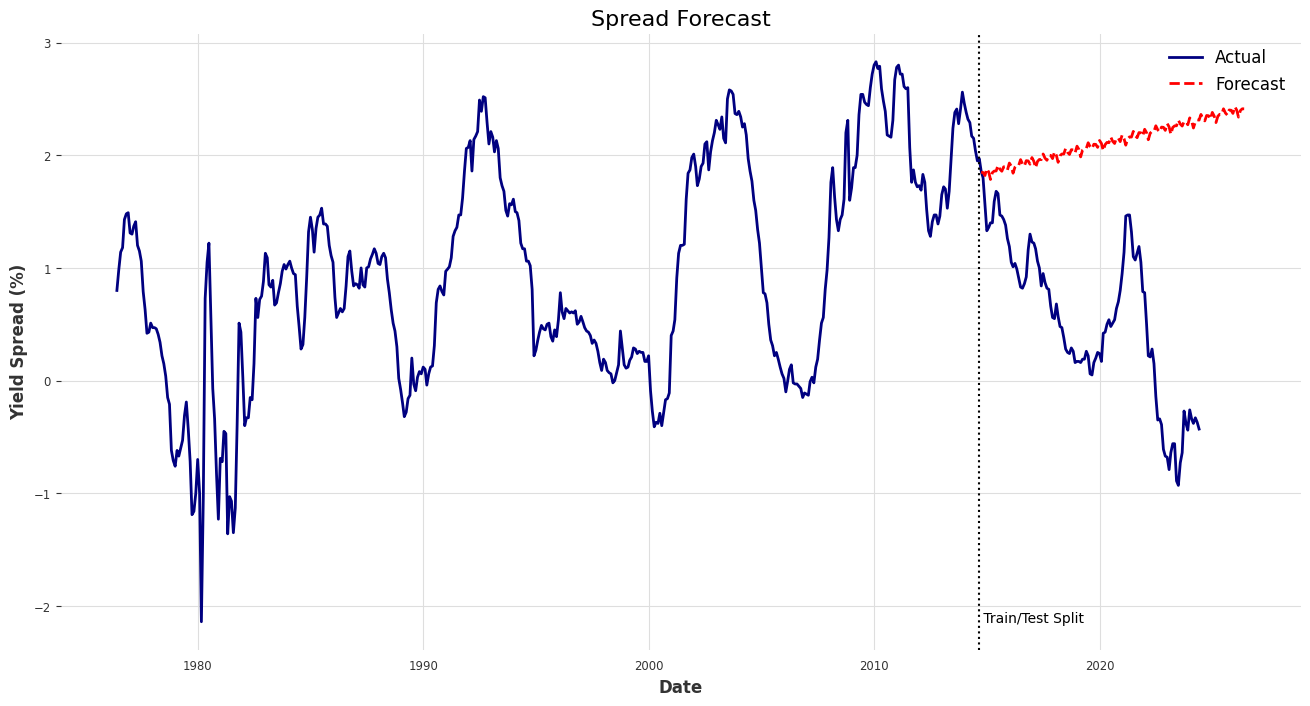

In [ ]:
series = TimeSeries.from_dataframe(data, value_cols='Yield_Spread')
train, test = series.split_before(0.8)

model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

print("\nTraining Prophet model...")
model.fit(train)


forecast = model.predict(len(test) + 24)  # Test period + 2 years


plt.figure(figsize=(16, 8))

series.plot(label='Actual', color='navy', linewidth=2)

forecast.plot(label='Forecast', color='red', linestyle='--', linewidth=2)


split_date = train.end_time()
plt.axvline(x=split_date, color='black', linestyle=':', linewidth=1.5)
plt.text(split_date, plt.ylim()[0]*0.9, ' Train/Test Split', fontsize=10)

plt.title('Spread Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Yield Spread (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [ ]:
try:
    data = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=T10Y2Y&scale=left&cosd=1976-06-01&coed=2024-06-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-01&revision_date=2024-06-01&nd=1976-06-01')
    df = data.rename(columns={'observation_date': 'ds', 'T10Y2Y': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.dropna()
    print(f"Data loaded successfully ({len(df)} records from {df['ds'].min().date()} to {df['ds'].max().date()})")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


Data loaded successfully (577 records from 1976-06-01 to 2024-06-01)


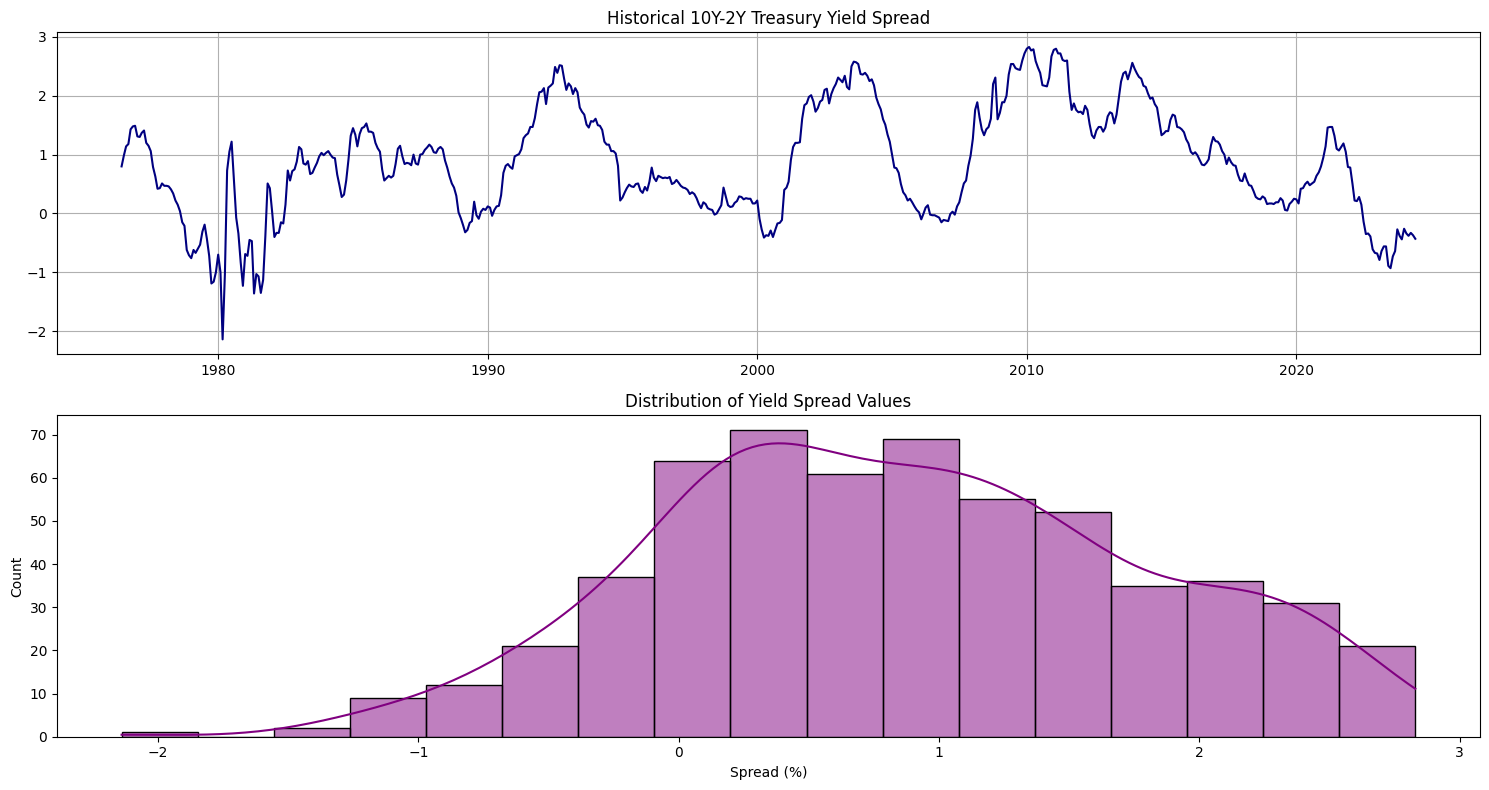

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df['ds'], df['y'], color='navy')
plt.title('Historical 10Y-2Y Treasury Yield Spread')
plt.grid(True)

plt.subplot(2, 1, 2)
sns.histplot(df['y'], kde=True, color='purple')
plt.title('Distribution of Yield Spread Values')
plt.xlabel('Spread (%)')
plt.tight_layout()
plt.show()

In [ ]:
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    interval_width=0.95,
    mcmc_samples=300
)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)

print("\nTraining Prophet model on full dataset...")
model.fit(df)


future = model.make_future_dataframe(periods=60, freq='M')
forecast = model.predict(future)

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1nod313a/n_6pzltd.json



Training Prophet model on full dataset...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1nod313a/tlexx7bv.json
20:10:12 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=45491', 'data', 'file=/tmp/tmp1nod313a/n_6pzltd.json', 'init=/tmp/tmp1nod313a/tlexx7bv.json', 'output', 'file=/tmp/tmp1nod313a/prophet_model4lpuoxpc/prophet_model-20250417201012_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=45491', 'data', 'file=/tmp/tmp1nod313a/n_6pzltd.json', 'init=/tmp/tmp1nod313a/tlexx7bv.json', 'output', 'file=/tmp/tmp1nod313a/prophet_model4lpuoxpc/prophet_model-20250417201012_2.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmds

20:11:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=45491', 'data', 'file=/tmp/tmp1nod313a/n_6pzltd.json', 'init=/tmp/tmp1nod313a/tlexx7bv.json', 'output', 'file=/tmp/tmp1nod313a/prophet_model4lpuoxpc/prophet_model-20250417201012_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1nod313a/prophet_model4lpuoxpc/prophet_model-20250417201012_1.csv
 console_msgs (if any):
	/tmp/tmp1nod313a/prophet_model4lpuoxpc/prophet_model-20250417201012_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 150
    num_warmup = 150
    save_warmup = 0 (Default)
    thin = 1 (Defau

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


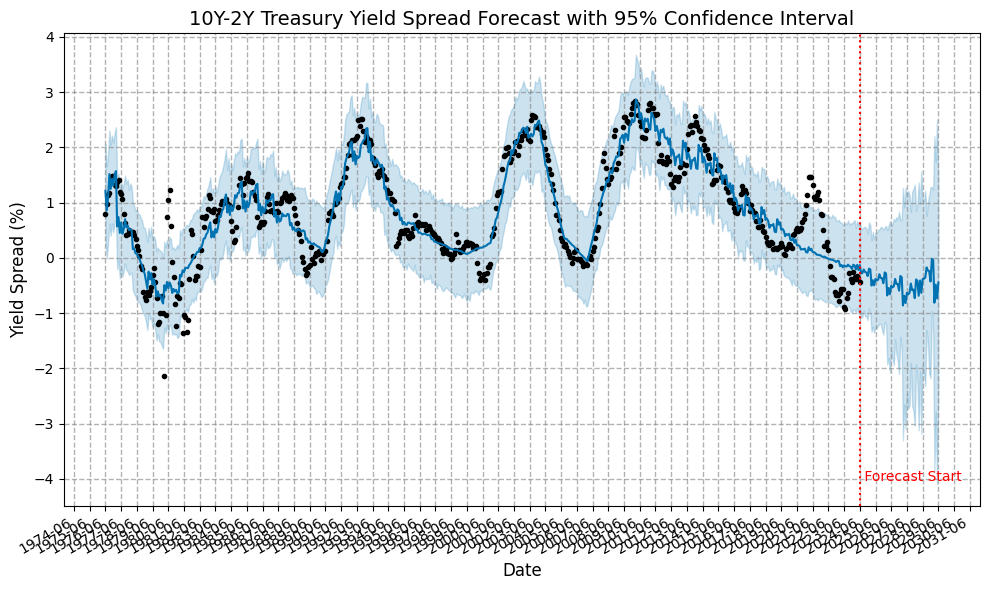

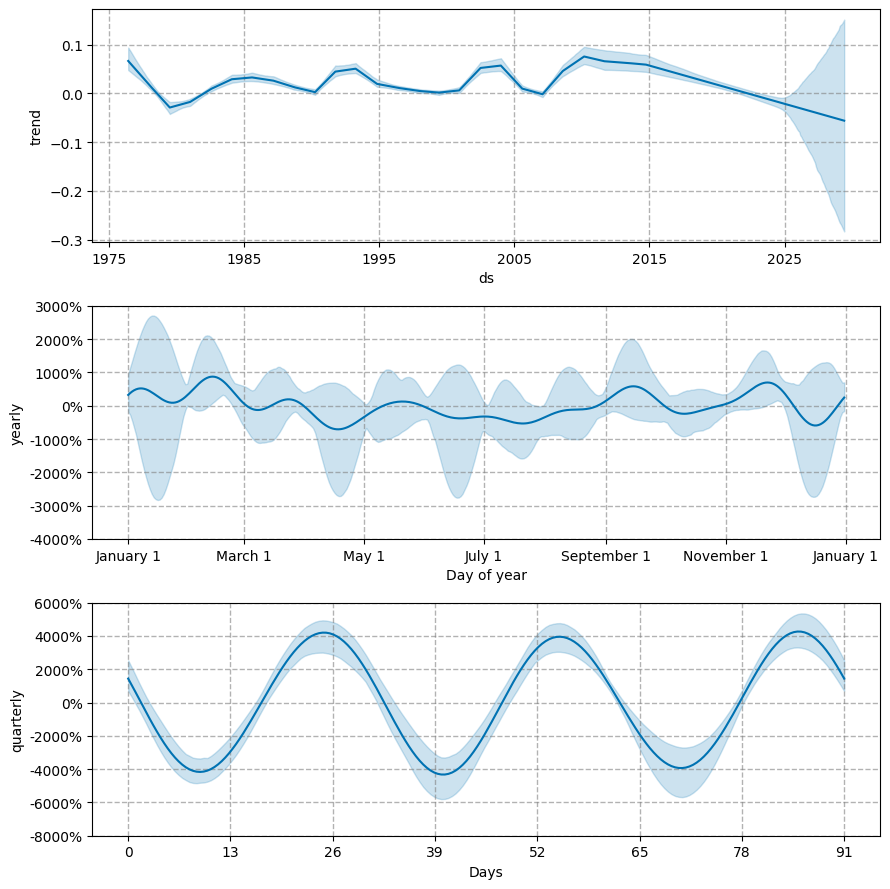

In [ ]:

fig = model.plot(forecast, uncertainty=True)
ax = fig.gca()
ax.set_title('10Y-2Y Treasury Yield Spread Forecast with 95% Confidence Interval', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Yield Spread (%)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

forecast_start = df['ds'].max()
ax.axvline(x=forecast_start, color='red', linestyle=':', linewidth=1.5)
ax.text(forecast_start, ax.get_ylim()[0]*0.9, ' Forecast Start', color='red')

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


fig2 = model.plot_components(forecast)
for ax in fig2.axes:
    ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

